In [1]:
!pip install blitz-bayesian-pytorch


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [4]:
start = -7
end = 7
n = 300
batch_size = 16

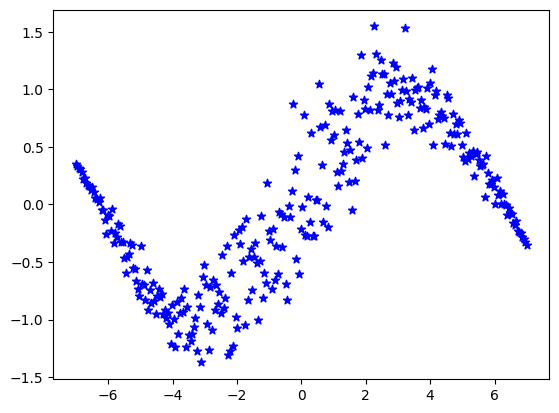

In [5]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

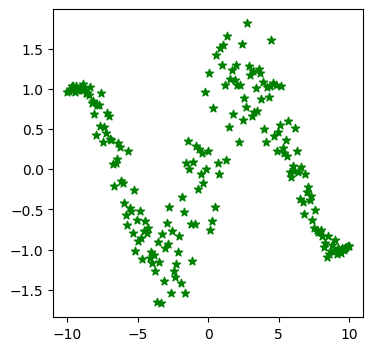

In [6]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

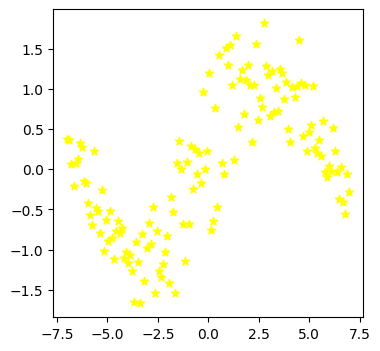

In [7]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


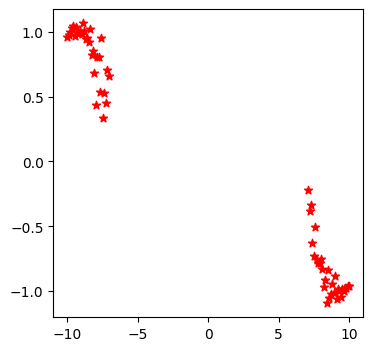

In [8]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [9]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class MCDO(nn.Module):
    def __init__(self):
        super(MCDO, self).__init__()
        hidden_size = 61

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h = self.dropout(torch.relu(self.fc1(x)))
        h = self.dropout(torch.relu(self.fc2(h)))
        out = self.out(h)
        return out



In [11]:
model = MCDO()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MCDO(
  (fc1): Linear(in_features=1, out_features=61, bias=True)
  (fc2): Linear(in_features=61, out_features=61, bias=True)
  (out): Linear(in_features=61, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Params: 3966


In [12]:
sns.set(rc={'figure.figsize':(4, 4)})
def make_plot_mcdo(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]
    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)
    df = pd.concat(dfs).reset_index()
    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)
    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*")
    plt.savefig("mcdo.png", dpi=300, bbox_inches='tight')  # Add this line
    plt.show()

In [13]:
def make_plot_mcdo_oodd(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test_oodd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_oodd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.1)
    plt.show()

In [14]:
def make_plot_mcdo_idd(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test_idd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_idd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.1)
    plt.show()

In [15]:
def MLE_mcdo():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [16]:
def MLE_mcdo_oodd():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo_oodd(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [17]:
def MLE_mcdo_idd():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo_idd(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


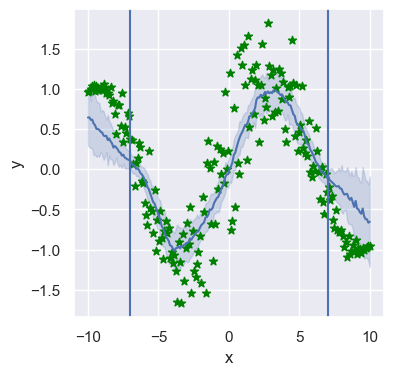

Epoch 149 | batch train loss: 0.0970262810587883 | test loss: 0.1555148380307051


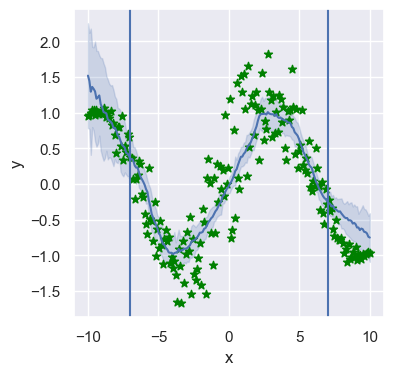

Epoch 149 | batch train loss: 0.08913149684667587 | test loss: 0.16648875176906586


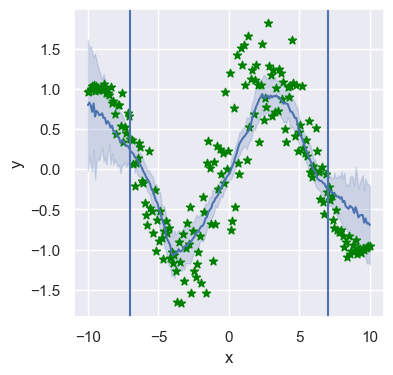

Epoch 149 | batch train loss: 0.06404124945402145 | test loss: 0.21483507752418518


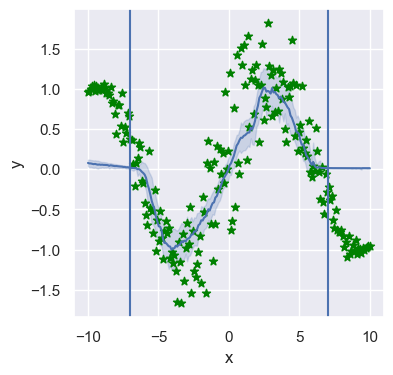

Epoch 149 | batch train loss: 0.07033096998929977 | test loss: 0.3560140155828916


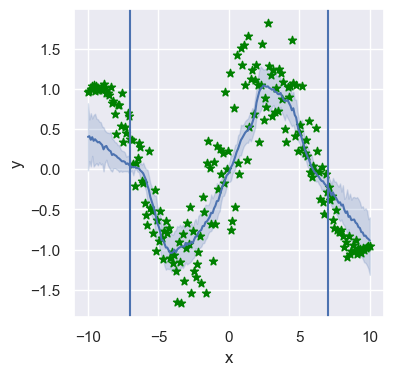

Epoch 149 | batch train loss: 0.16601985692977905 | test loss: 0.20784417253274184


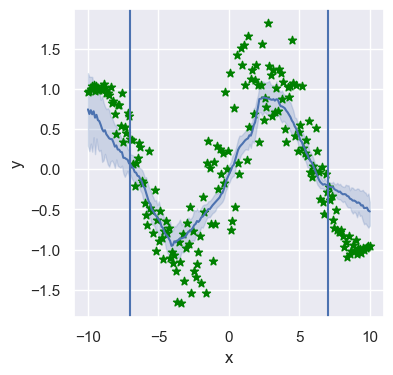

Epoch 149 | batch train loss: 0.16349713504314423 | test loss: 0.17522342617695147


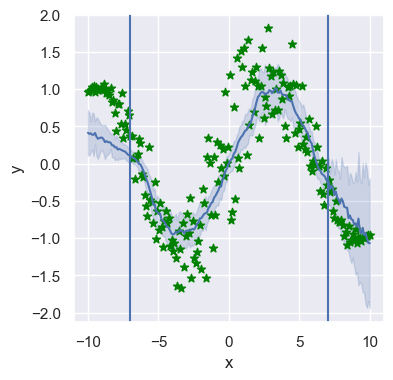

Epoch 149 | batch train loss: 0.06148490309715271 | test loss: 0.17890562231724078


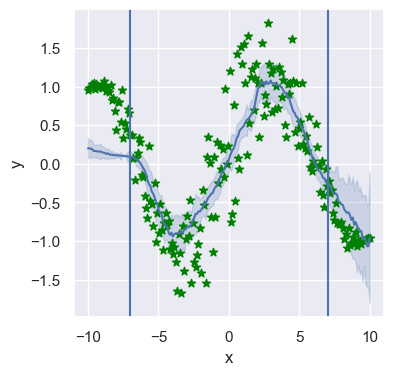

Epoch 149 | batch train loss: 0.027515733614563942 | test loss: 0.23744696092147094


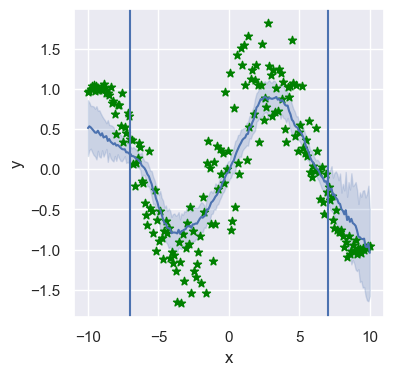

Epoch 149 | batch train loss: 0.08688515424728394 | test loss: 0.176140930217046


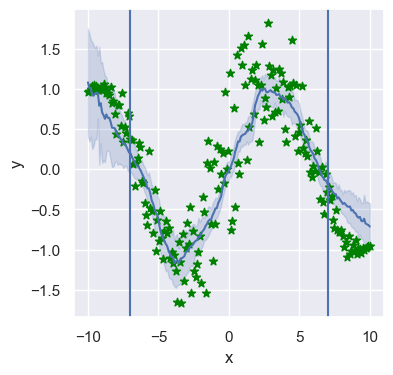

Epoch 149 | batch train loss: 0.07884876430034637 | test loss: 0.19656826097231644


In [18]:
train_losses=[]
test_losses=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)


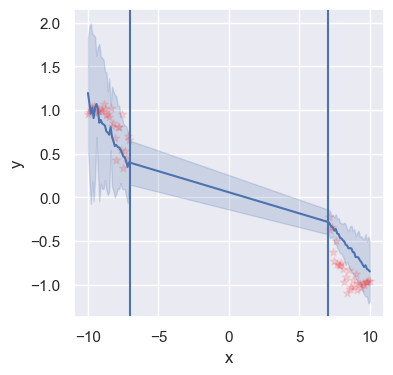

Epoch 149 | batch train loss: 0.07427515089511871 | test loss: 0.11186569929122925


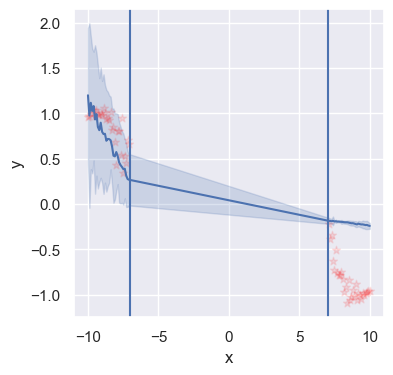

Epoch 149 | batch train loss: 0.024437541142106056 | test loss: 0.2633625026792288


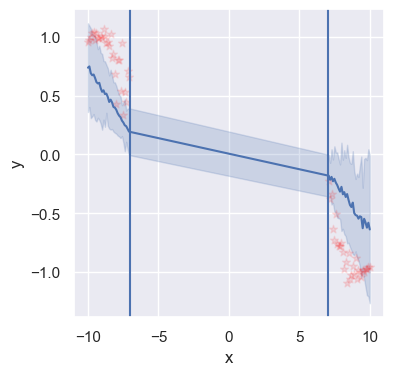

Epoch 149 | batch train loss: 0.09022321552038193 | test loss: 0.2678448520600796


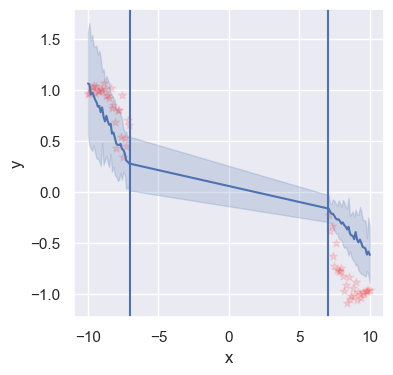

Epoch 149 | batch train loss: 0.031037837266921997 | test loss: 0.1649353690445423


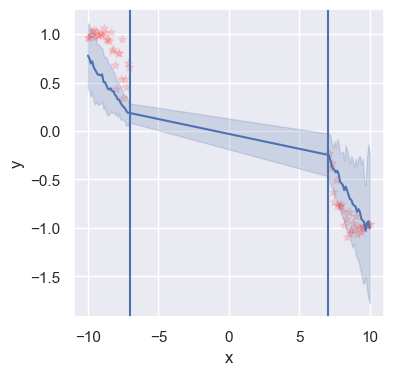

Epoch 149 | batch train loss: 0.05839720740914345 | test loss: 0.14747303538024426


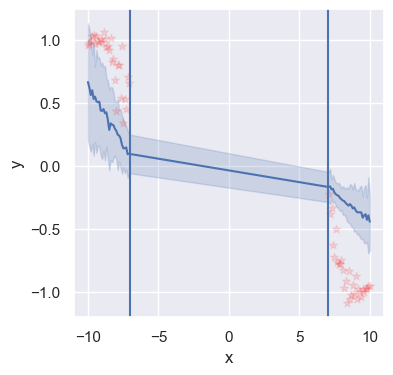

Epoch 149 | batch train loss: 0.09557444602251053 | test loss: 0.1844782717525959


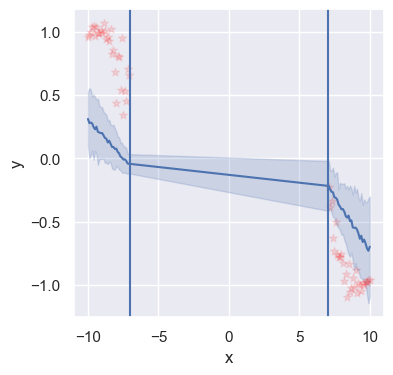

Epoch 149 | batch train loss: 0.058964941650629044 | test loss: 0.12817363999783993


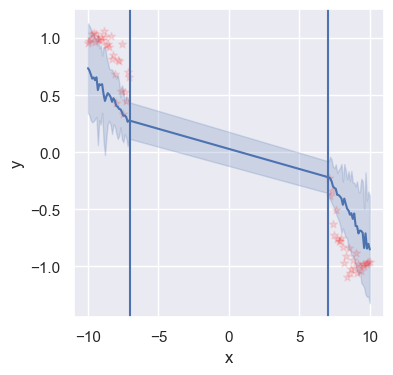

Epoch 149 | batch train loss: 0.03292427584528923 | test loss: 0.16619450598955154


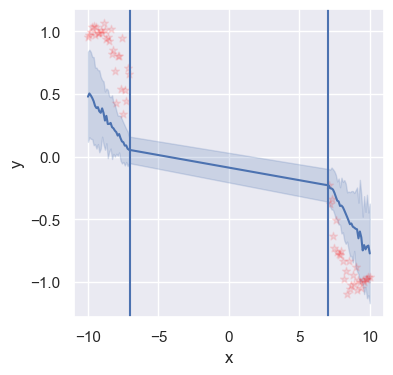

Epoch 149 | batch train loss: 0.05641830340027809 | test loss: 0.33436474204063416


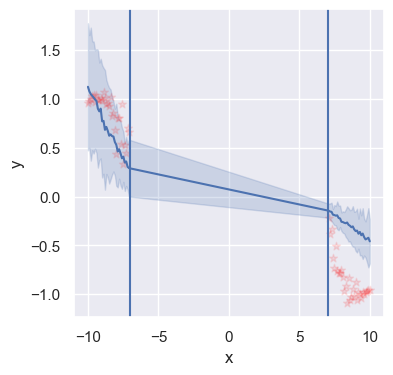

Epoch 149 | batch train loss: 0.02917618490755558 | test loss: 0.08917117211967707


In [19]:
train_losses_oodd=[]
test_losses_oodd=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)


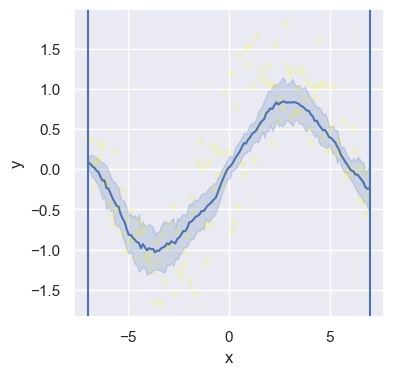

Epoch 149 | batch train loss: 0.030499598011374474 | test loss: 0.20245308801531792


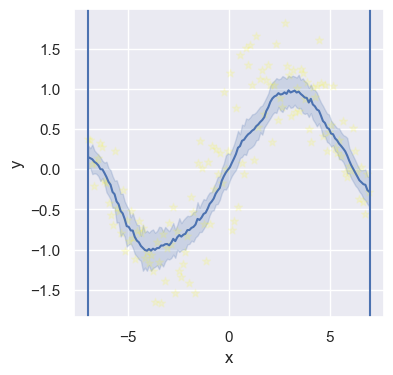

Epoch 149 | batch train loss: 0.03242870420217514 | test loss: 0.23615941405296326


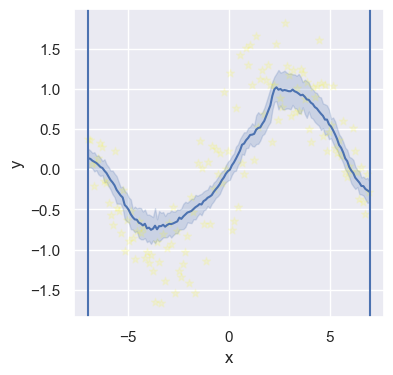

Epoch 149 | batch train loss: 0.03944114223122597 | test loss: 0.1951996303266949


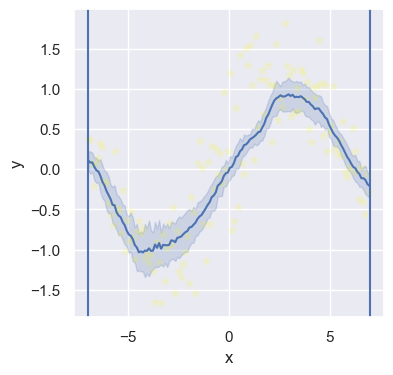

Epoch 149 | batch train loss: 0.04123080149292946 | test loss: 0.2000079419877794


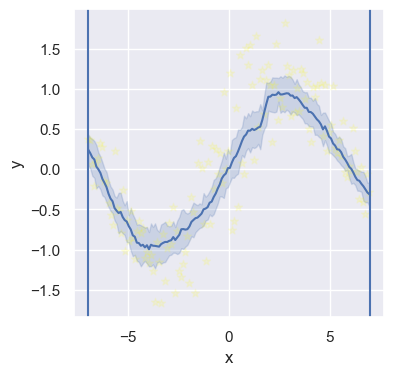

Epoch 149 | batch train loss: 0.05159516632556915 | test loss: 0.19827747841676077


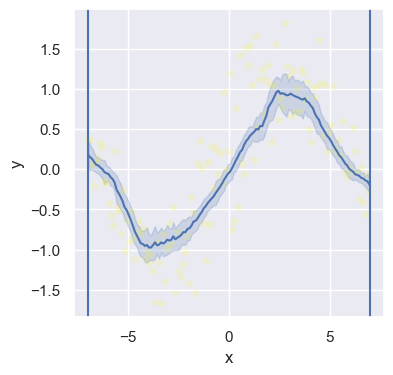

Epoch 149 | batch train loss: 0.052421022206544876 | test loss: 0.20605729189183977


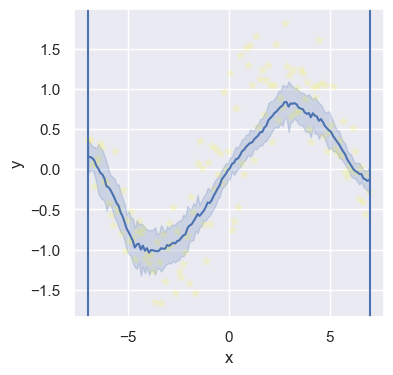

Epoch 149 | batch train loss: 0.053083907812833786 | test loss: 0.1983135077688429


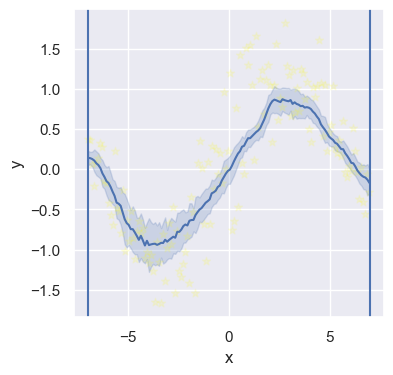

Epoch 149 | batch train loss: 0.07860802859067917 | test loss: 0.19411039683553907


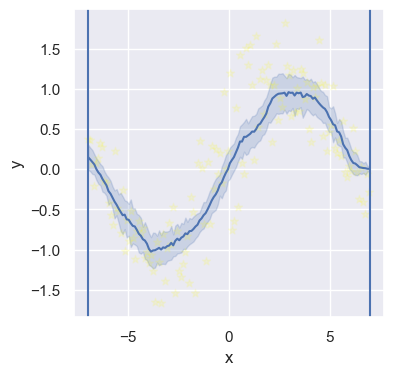

Epoch 149 | batch train loss: 0.0337337963283062 | test loss: 0.20142333871788448


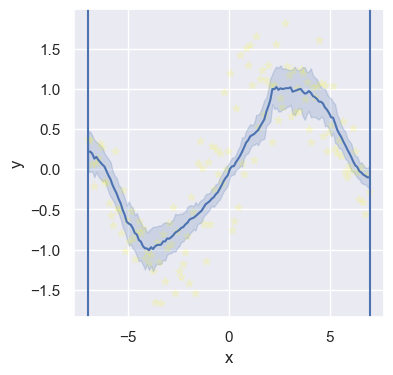

Epoch 149 | batch train loss: 0.090487539768219 | test loss: 0.19939759539233315


In [20]:
train_losses_idd=[]
test_losses_idd=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)


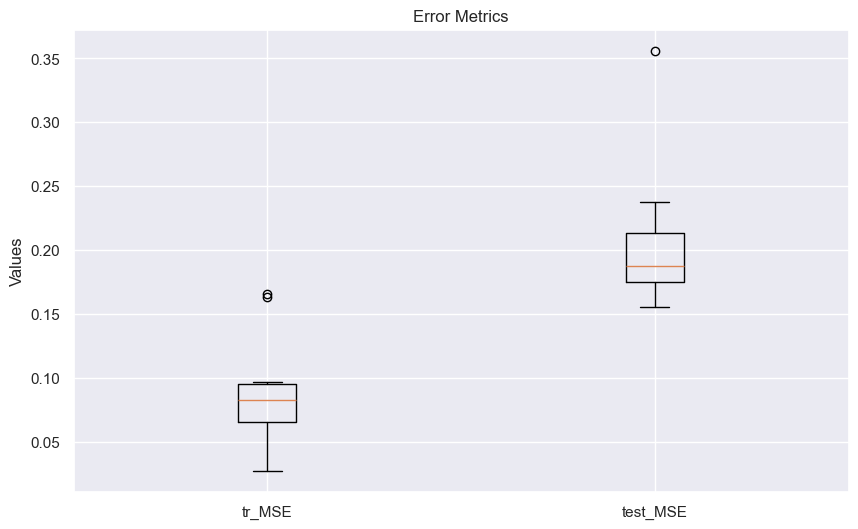

In [21]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values]
box_labels = ['tr_MSE', 'test_MSE']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [22]:

# mean_gaus_train_loss = np.mean(tr_loss_values)
# std_dev_gaus_train_loss = np.std(tr_loss_values)

# mean_gaus_test_loss = np.mean(test_loss_values)
# std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_loss_values)
std_dev_mse_train = np.std(tr_loss_values)

mean_mse_test = np.mean(test_loss_values)
std_dev_mse_test = np.std(test_loss_values)

# print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
# print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

# print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
# print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of MSE Training of 10 runs  0.09047815445810556
Standard Deviation of MSE Training of 10 runs  0.041401519541954174
Mean of MSE Testing of 10 runs  0.20649820560446153
Standard Deviation of MSE Testing of 10 runs  0.05508521449987275


In [23]:
# Create a DataFrame from the lists
data = {
    'Training MSE': tr_loss_values,
    'Testing MSE': test_loss_values,

}

num_columns = len(data)

column_names = ['Training MSE','Testing MSE']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_mcdnn.csv', index=True)

    Training MSE  Testing MSE
1       0.097026     0.155515
2       0.089131     0.166489
3       0.064041     0.214835
4       0.070331     0.356014
5       0.166020     0.207844
6       0.163497     0.175223
7       0.061485     0.178906
8       0.027516     0.237447
9       0.086885     0.176141
10      0.078849     0.196568


In [24]:
print(test_loss_values)

[0.1555148380307051, 0.16648875176906586, 0.21483507752418518, 0.3560140155828916, 0.20784417253274184, 0.17522342617695147, 0.17890562231724078, 0.23744696092147094, 0.176140930217046, 0.19656826097231644]
